<a href="https://colab.research.google.com/github/kimjinseong-ctrl/DScover_Guide_Project_G/blob/main/G_Guide_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 결측치 파악

In [ ]:
import random
import pandas as pd
import numpy as np
import os

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building = pd.read_csv('building_info.csv')

In [ ]:
building.info() # 결측치 없음, 실수형 2개, 정수형 1개, 문자형 4개, 태양광 용량이 문자형인것은 문제

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [ ]:
building = building.replace('-', np.nan)
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    building[col] = building[col].astype(float).fillna(0)

In [ ]:
building.head() # 태양광용량을 실수로 표현

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,호텔,82912.71,77586.00,0.00,0.0,0.0
1,2,상용,40658.90,30392.82,0.00,0.0,0.0
2,3,병원,560431.00,418992.00,278.58,0.0,0.0
3,4,호텔,41813.29,23715.71,0.00,0.0,0.0
4,5,학교,403749.39,248507.00,1983.05,1025.0,250.0


In [ ]:
train = pd.merge(train, building, on='건물번호')
test = pd.merge(test, building, on='건물번호')
train.head()

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,호텔,82912.71,77586.0,0.0,0.0,0.0
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,호텔,82912.71,77586.0,0.0,0.0,0.0
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,호텔,82912.71,77586.0,0.0,0.0,0.0
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,호텔,82912.71,77586.0,0.0,0.0,0.0
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,호텔,82912.71,77586.0,0.0,0.0,0.0


In [ ]:
train.info(), test.info() # 세가지 데이터셋에 결측치가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(°C)         204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  건물유형           204000 non-null  object 
 11  연면적(m2)        204000 non-null  float64
 12  냉방면적(m2)       204000 non-null  float64
 13  태양광용량(kW)      204000 non-null  float64
 14  ESS저장용량(kWh)   204000 non-null  float64
 15  PCS용량(kW)      204000 non-null  float64
dtypes: float64(12), int64(1), object(3)
memory usage: 24.9+ MB
<class 'pandas.

(None, None)

### 이상치 탐지

In [ ]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'],
      dtype='object')

In [ ]:
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

train.head()

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),month,day,time
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,호텔,82912.71,77586.0,0.0,0.0,0.0,6,1,0
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,호텔,82912.71,77586.0,0.0,0.0,0.0,6,1,1
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,호텔,82912.71,77586.0,0.0,0.0,0.0,6,1,2
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,호텔,82912.71,77586.0,0.0,0.0,0.0,6,1,3
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,호텔,82912.71,77586.0,0.0,0.0,0.0,6,1,4


In [ ]:
import pandas as pd
import numpy as np


train_df = pd.read_csv('train.csv', encoding='utf-8')
building_info_df = pd.read_csv('building_info.csv', encoding='utf-8')


merged_df = pd.merge(train_df, building_info_df[['건물번호', '건물유형']], on='건물번호', how='left')

merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H')

outliers_with_details = {}
print("건물별 이상치 탐지 시작 (IQR 방법 사용)...")

for building_num, group_df in merged_df.groupby('건물번호'):

    if len(group_df) < 4:
        continue

    power_series = group_df['전력소비량(kWh)']

    Q1 = power_series.quantile(0.25)
    Q3 = power_series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_series = power_series[(power_series < lower_bound) | (power_series > upper_bound)]

    if not outliers_series.empty:
        outlier_rows = group_df.loc[outliers_series.index]
        building_type = group_df['건물유형'].iloc[0]

        outliers_with_details[building_num] = {
            '건물유형': building_type,
            '정상범위': (lower_bound, upper_bound),
            '이상치_목록': outlier_rows[['일시', '전력소비량(kWh)']].to_dict('records')
        }

print("이상치 탐지 완료.")
print("\n--- 이상치 탐지 결과 (건물유형, 정상범위, 날짜 포함) ---")

if not outliers_with_details:
    print("탐지된 이상치가 없습니다.")
else:
    for building_num, details in outliers_with_details.items():
        building_type = details['건물유형']
        lower_b, upper_b = details['정상범위']
        found_outliers = details['이상치_목록']

        print(f"\n 건물번호 {building_num} (유형: {building_type})")
        print(f"  - 정상 전력소비량 범위: {lower_b:.2f} ~ {upper_b:.2f} kWh")
        print(f"  - 탐지된 이상치 ({len(found_outliers)}개):")

        for info in found_outliers:
            date_str = info['일시'].strftime('%Y-%m-%d %H:%M')
            power_val = info['전력소비량(kWh)']
            print(f"    - 날짜: {date_str}, 전력소비량: {power_val:.2f} kWh")


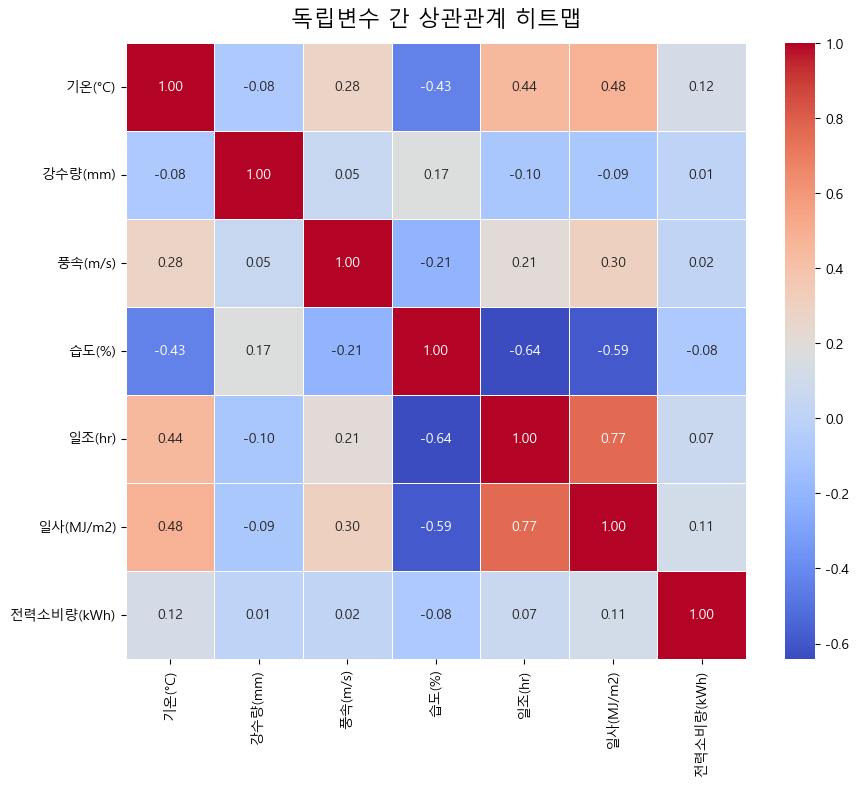

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

numeric_columns = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
df_for_corr = train_df[numeric_columns]

correlation_matrix = df_for_corr.corr()

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
heatmap.set_title('독립변수 간 상관관계 히트맵', fontsize=16, pad=12)
plt.savefig('heatmap.png')
plt.show()

'월별_데이터_변화_6월.png' 파일이 저장되었습니다.


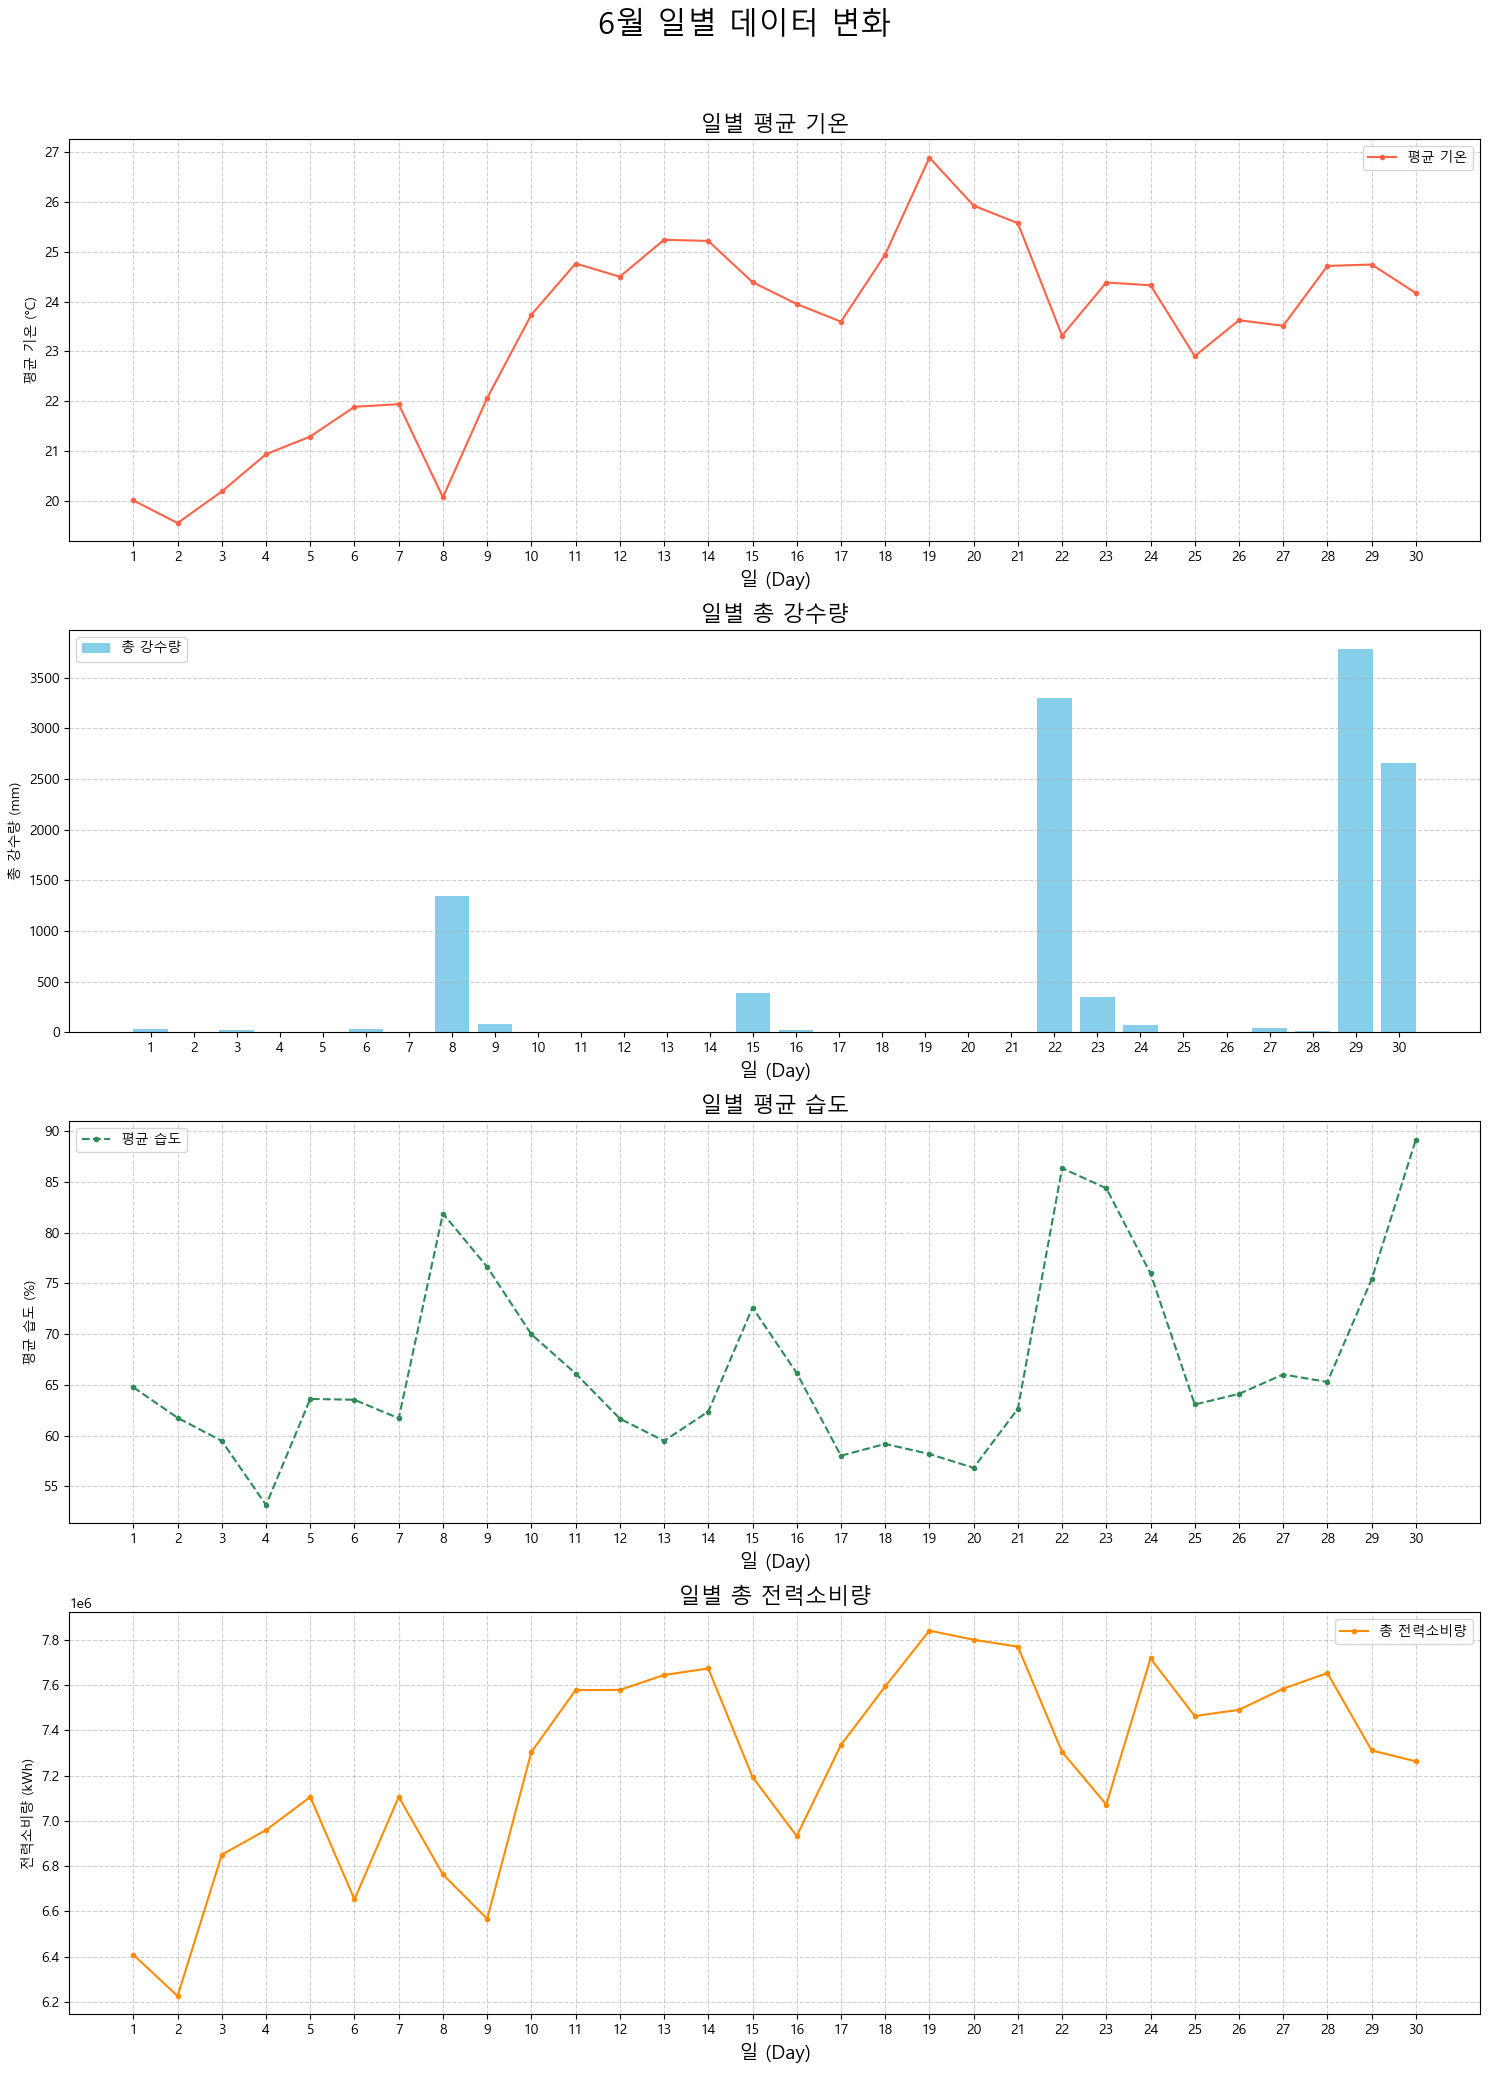

'월별_데이터_변화_7월.png' 파일이 저장되었습니다.


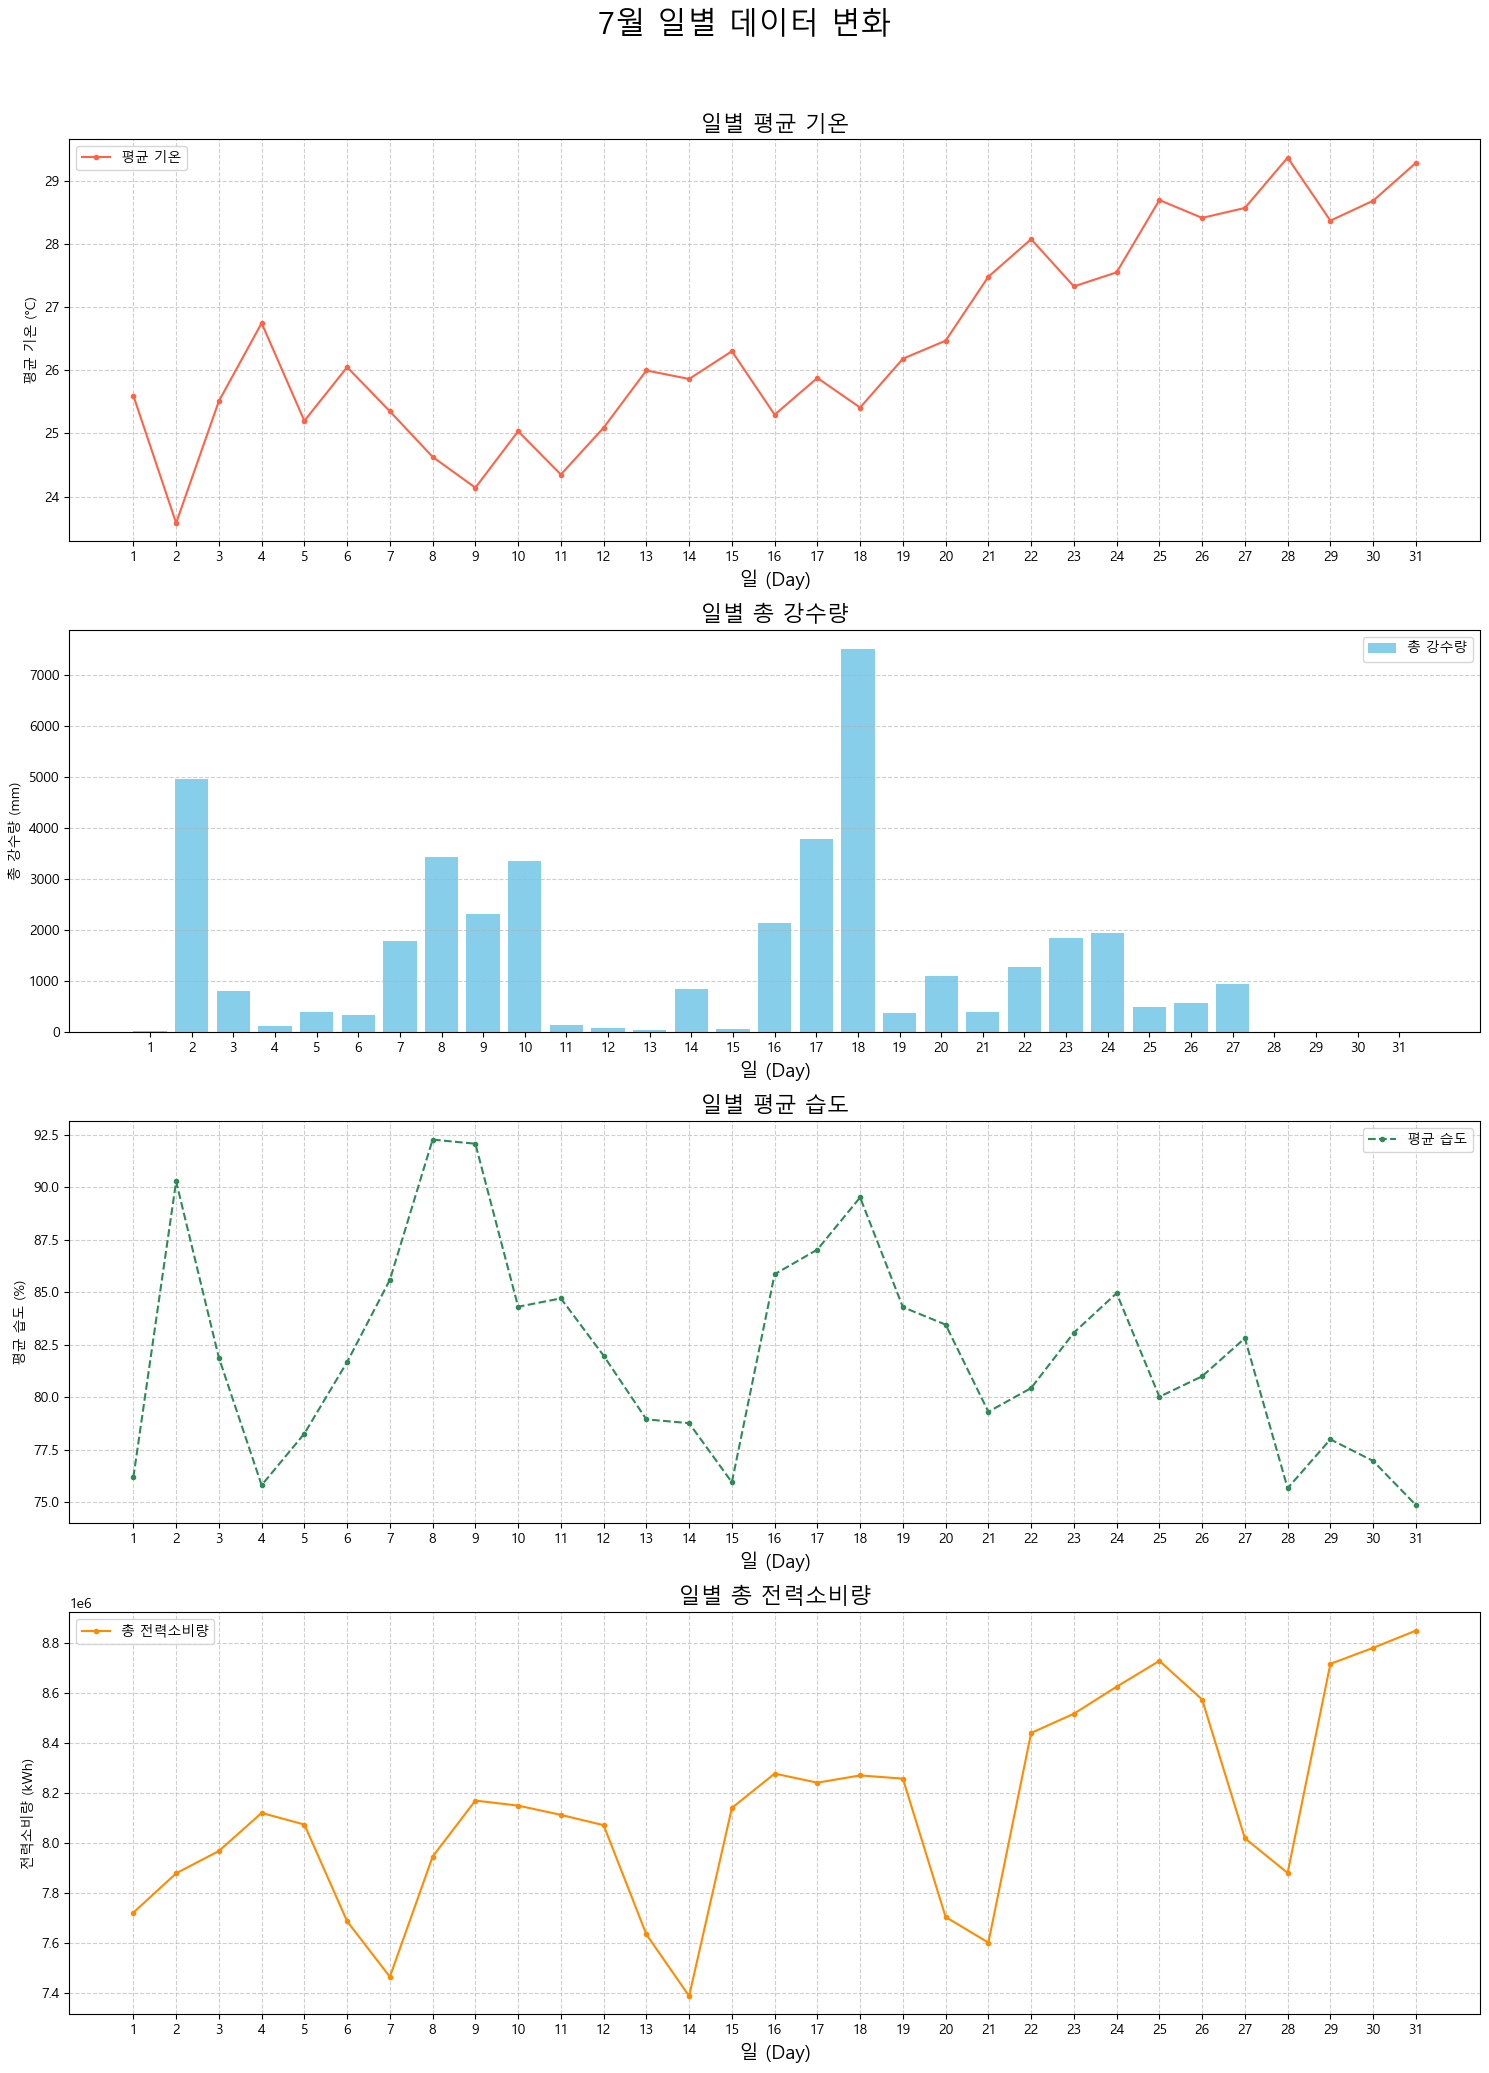

'월별_데이터_변화_8월.png' 파일이 저장되었습니다.


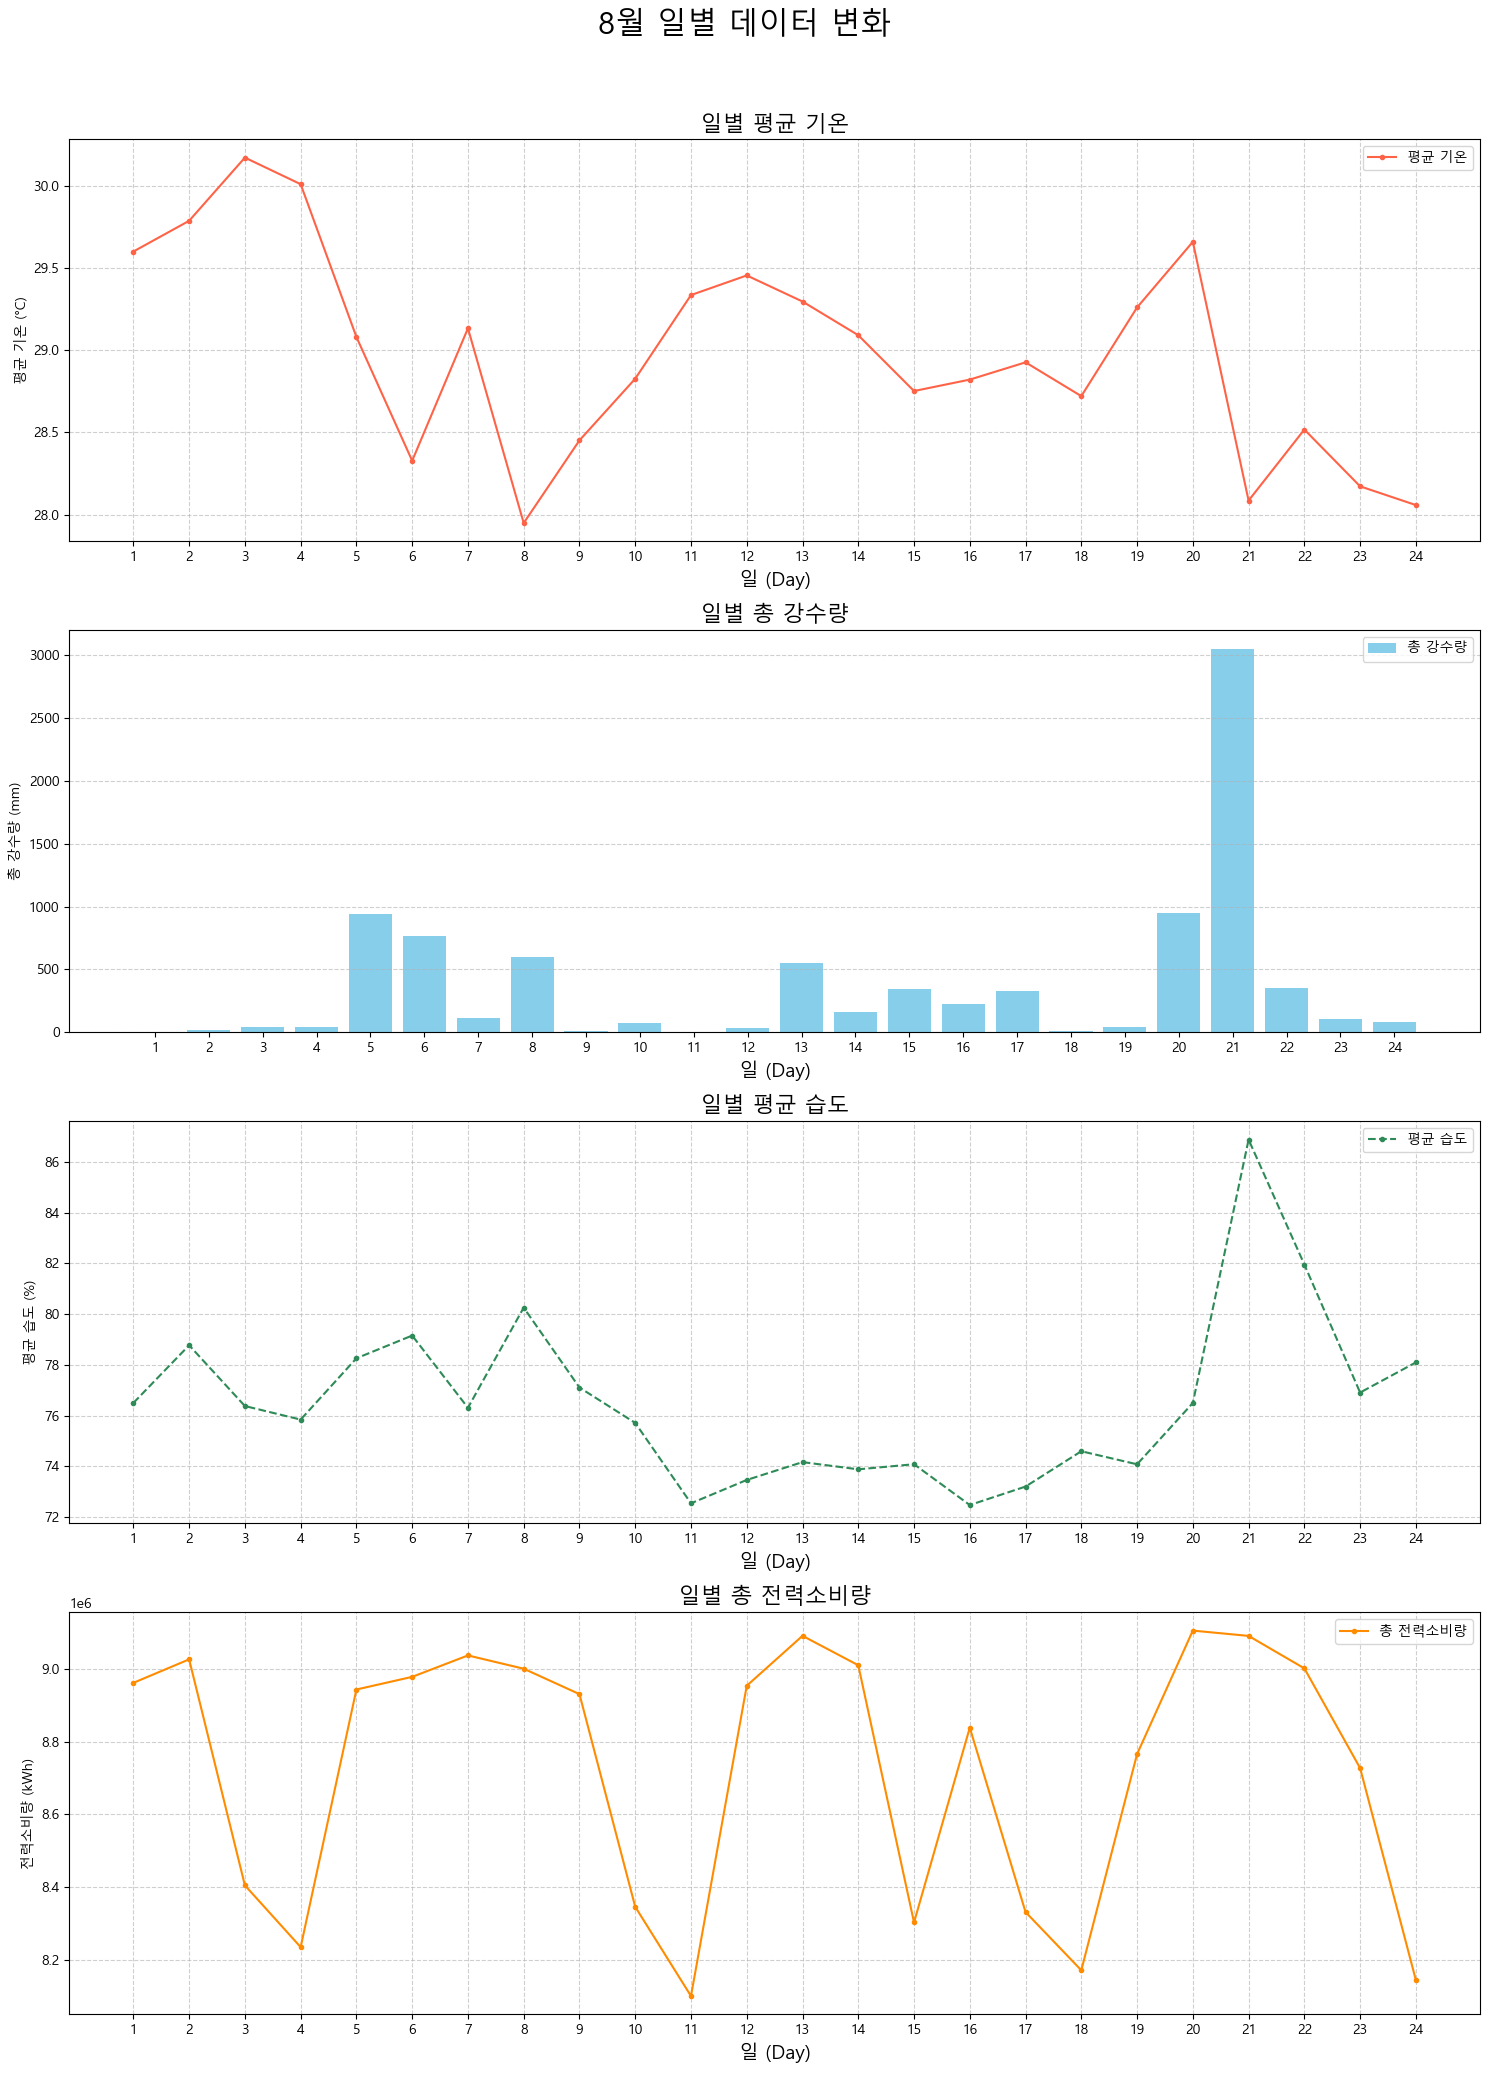


모든 그래프 생성이 완료되었습니다.
'월별_데이터_변화_8월.png' 파일이 저장되었습니다.


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

try:
    plt.rc('font', family='Malgun Gothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Malgun Gothic 폰트를 찾을 수 없습니다. 다른 한글 폰트를 설정해주세요.")

# 데이터 불러오기 및 전처리

train_df = pd.read_csv('train.csv', encoding='utf-8')

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['일자'] = train_df['일시'].dt.date

daily_stats = train_df.groupby('일자').agg({
    '월': 'first',
    '일': 'first',
    '기온(°C)': 'mean',
    '강수량(mm)': 'sum',
    '습도(%)': 'mean',
    '전력소비량(kWh)': 'sum'
}).reset_index()

월별 시각화 및 파일 저장
for month in [6, 7, 8]:
    month_df = daily_stats[daily_stats['월'] == month]

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 22))

    fig.suptitle(f'{month}월 일별 데이터 변화', fontsize=22, y=0.97)

    axes[0].plot(month_df['일'], month_df['기온(°C)'], marker='.', linestyle='-', color='tomato', label='평균 기온')
    axes[0].set_title('일별 평균 기온', fontsize=16)
    axes[0].set_ylabel('평균 기온 (°C)')
    axes[0].set_xlabel('일 (Day)', fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    axes[1].bar(month_df['일'], month_df['강수량(mm)'], color='skyblue', label='총 강수량')
    axes[1].set_title('일별 총 강수량', fontsize=16)
    axes[1].set_ylabel('총 강수량 (mm)')
    axes[1].set_xlabel('일 (Day)', fontsize=14)
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)
    axes[1].legend()

    axes[2].plot(month_df['일'], month_df['습도(%)'], marker='.', linestyle='--', color='seagreen', label='평균 습도')
    axes[2].set_title('일별 평균 습도', fontsize=16)
    axes[2].set_ylabel('평균 습도 (%)')
    axes[2].set_xlabel('일 (Day)', fontsize=14)
    axes[2].grid(True, linestyle='--', alpha=0.6)
    axes[2].legend()

    axes[3].plot(month_df['일'], month_df['전력소비량(kWh)'], marker='.', linestyle='-', color='darkorange', label='총 전력소비량')
    axes[3].set_title('일별 총 전력소비량', fontsize=16)
    axes[3].set_ylabel('전력소비량 (kWh)')
    axes[3].set_xlabel('일 (Day)', fontsize=14)
    axes[3].grid(True, linestyle='--', alpha=0.6)
    axes[3].legend()

    for ax in axes:
        ax.set_xticks(month_df['일'])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    file_name = f'월별_데이터_변화_{month}월.png'
    plt.savefig(file_name, dpi=300)

    plt.show()

file_name = f'월별_데이터_변화_{month}월.png'
plt.savefig(file_name, dpi=300)


'시간대별_데이터_패턴.png' 파일이 성공적으로 저장되었습니다.


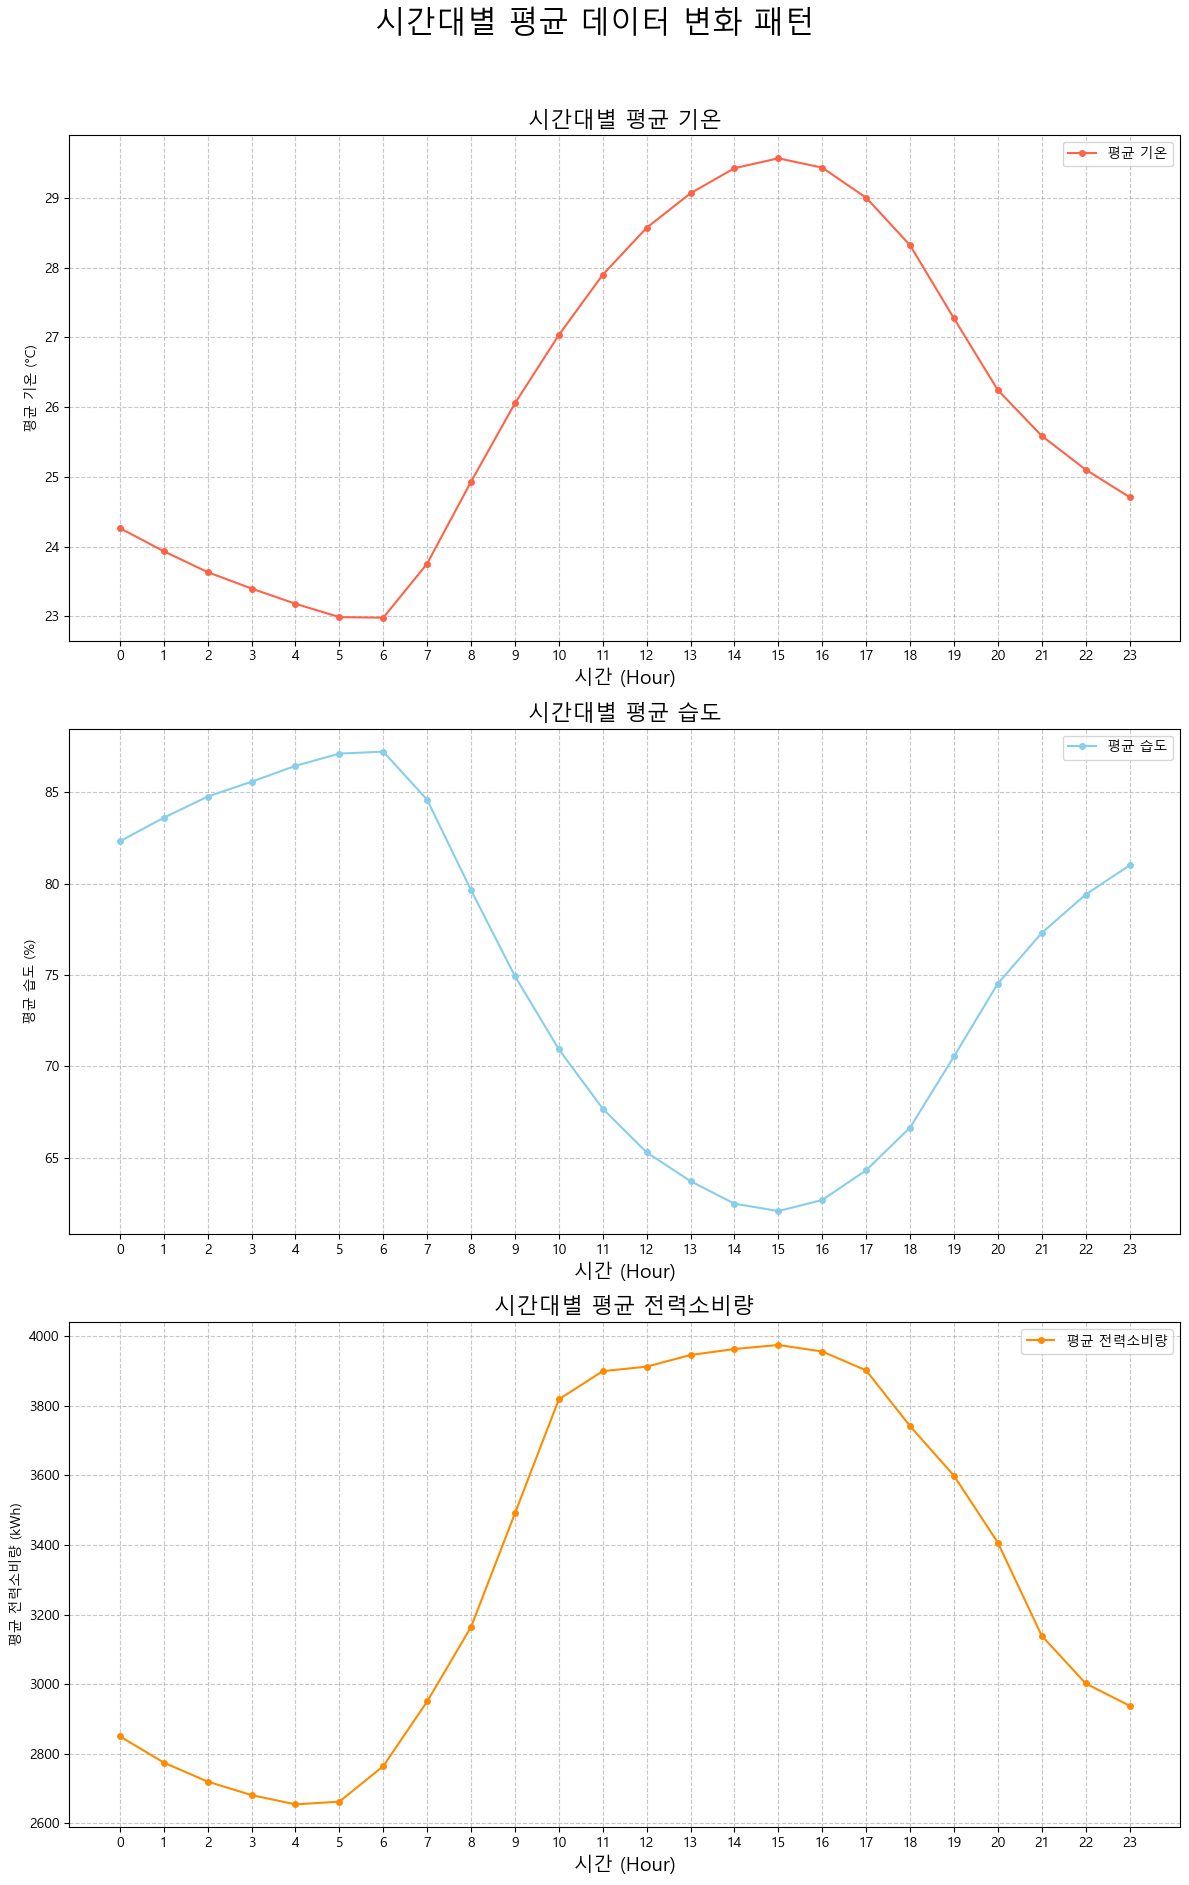

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# '일시' 열에서 '시간' 정보만 추출하여 새로운 열을 만들기
train_df['시간'] = train_df['일시'].dt.hour

# '시간'을 기준으로 그룹화하여 각 변수의 시간대별 평균을 계산합니다.
hourly_stats = train_df.groupby('시간').agg({
    '기온(°C)': 'mean',
    '습도(%)': 'mean',
    '전력소비량(kWh)': 'mean'
}).reset_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

fig.suptitle('시간대별 평균 데이터 변화 패턴', fontsize=22, y=0.97)

axes[0].plot(hourly_stats['시간'], hourly_stats['기온(°C)'], marker='o', markersize=4, linestyle='-', color='tomato', label='평균 기온')
axes[0].set_title('시간대별 평균 기온', fontsize=16)
axes[0].set_ylabel('평균 기온 (°C)')
axes[0].set_xlabel('시간 (Hour)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

axes[1].plot(hourly_stats['시간'], hourly_stats['습도(%)'], marker='o', markersize=4, linestyle='-', color='skyblue', label='평균 습도')
axes[1].set_title('시간대별 평균 습도', fontsize=16)
axes[1].set_ylabel('평균 습도 (%)')
axes[1].set_xlabel('시간 (Hour)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

axes[2].plot(hourly_stats['시간'], hourly_stats['전력소비량(kWh)'], marker='o', markersize=4, linestyle='-', color='darkorange', label='평균 전력소비량')
axes[2].set_title('시간대별 평균 전력소비량', fontsize=16)
axes[2].set_ylabel('평균 전력소비량 (kWh)')
axes[2].set_xlabel('시간 (Hour)', fontsize=14)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend()

for ax in axes:
    ax.set_xticks(hourly_stats['시간'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

file_name = '시간대별_데이터_패턴.png'
plt.savefig(file_name, dpi=300)

plt.show()



각 건물유형별로 박스 플롯을 생성하고 파일로 저장합니다...
'건물유형별_전력소비량_분포_호텔.png' 파일이 저장되었습니다.


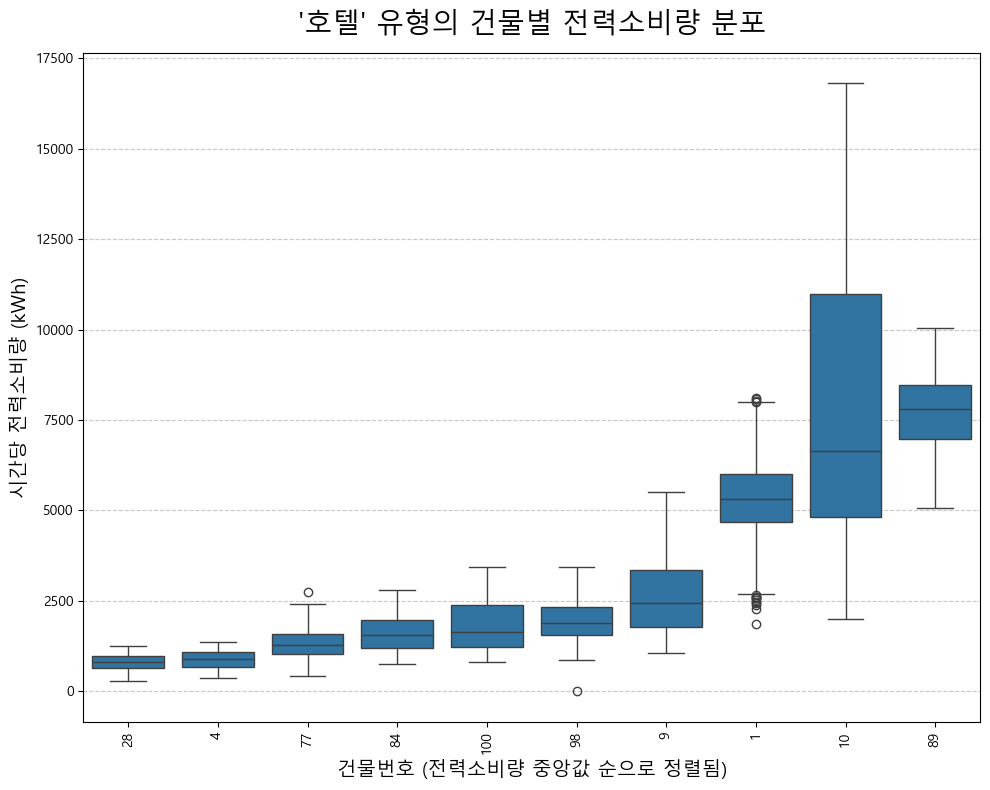

'건물유형별_전력소비량_분포_상용.png' 파일이 저장되었습니다.


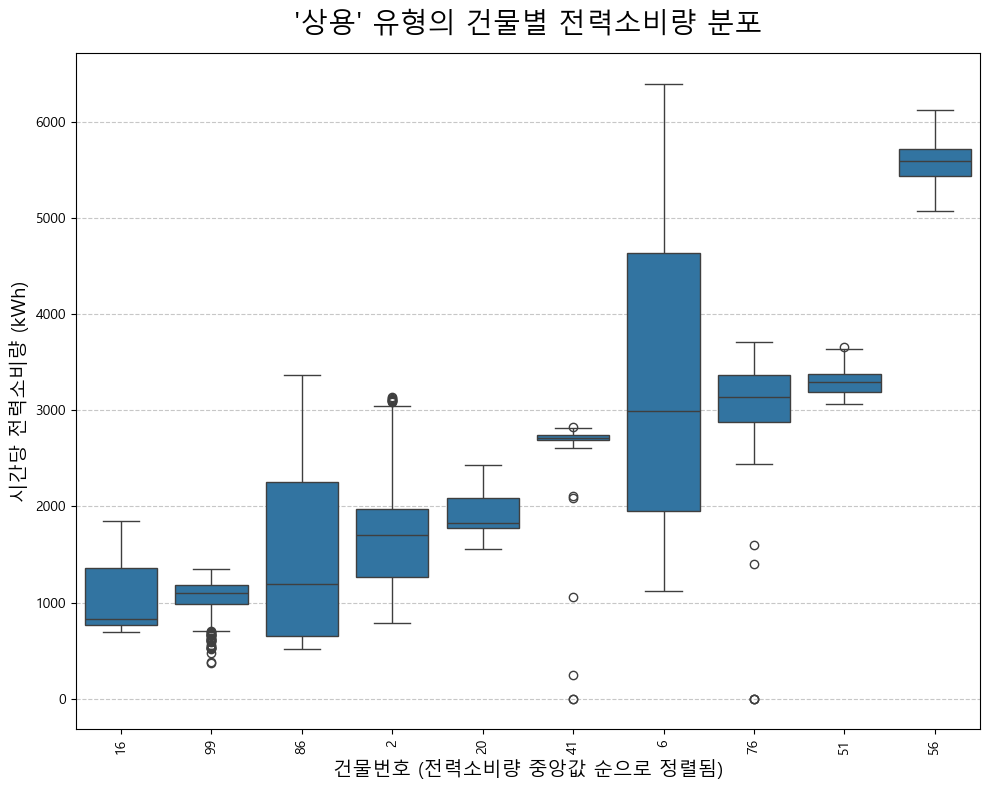

'건물유형별_전력소비량_분포_병원.png' 파일이 저장되었습니다.


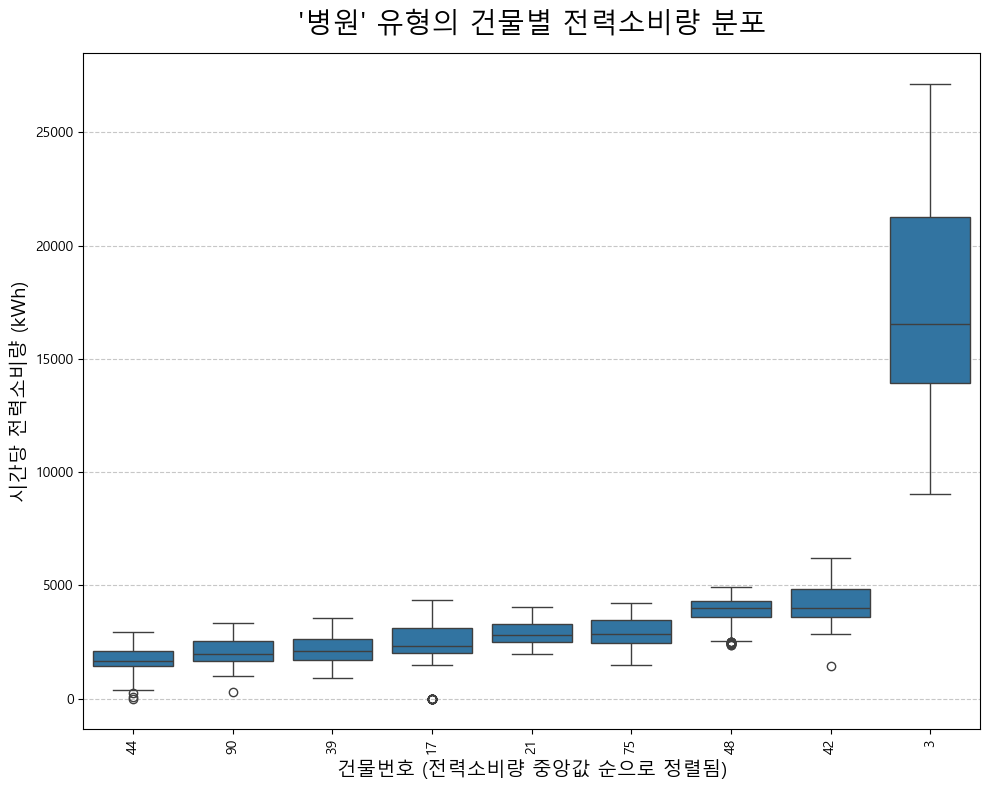

'건물유형별_전력소비량_분포_학교.png' 파일이 저장되었습니다.


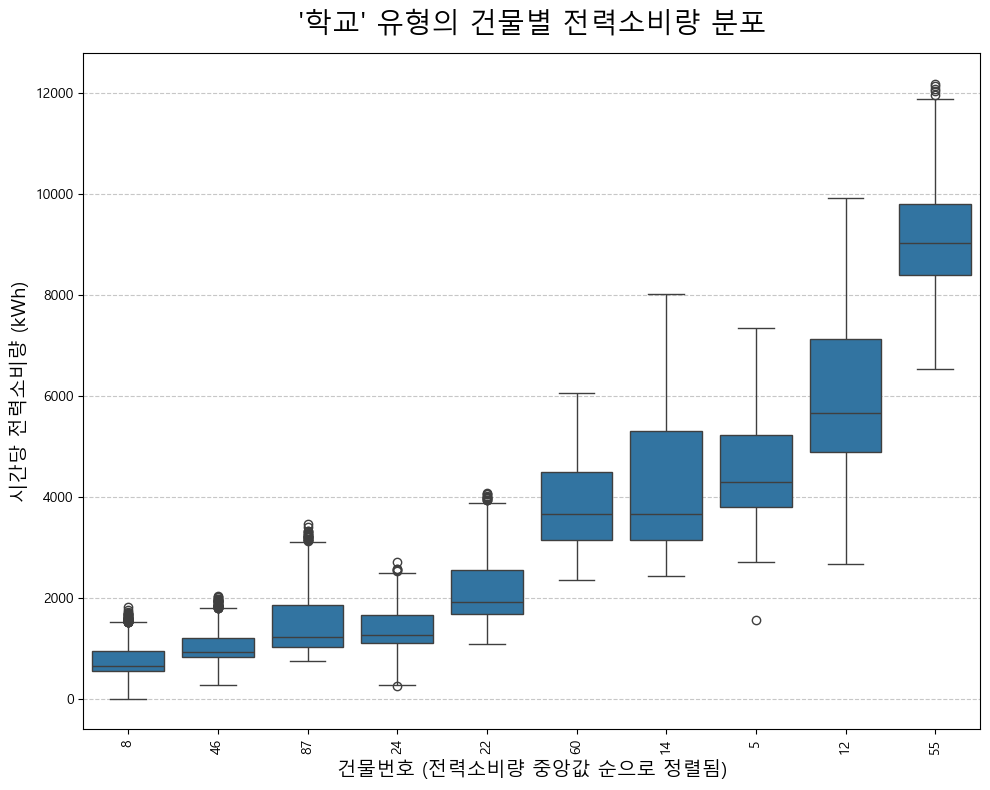

'건물유형별_전력소비량_분포_건물기타.png' 파일이 저장되었습니다.


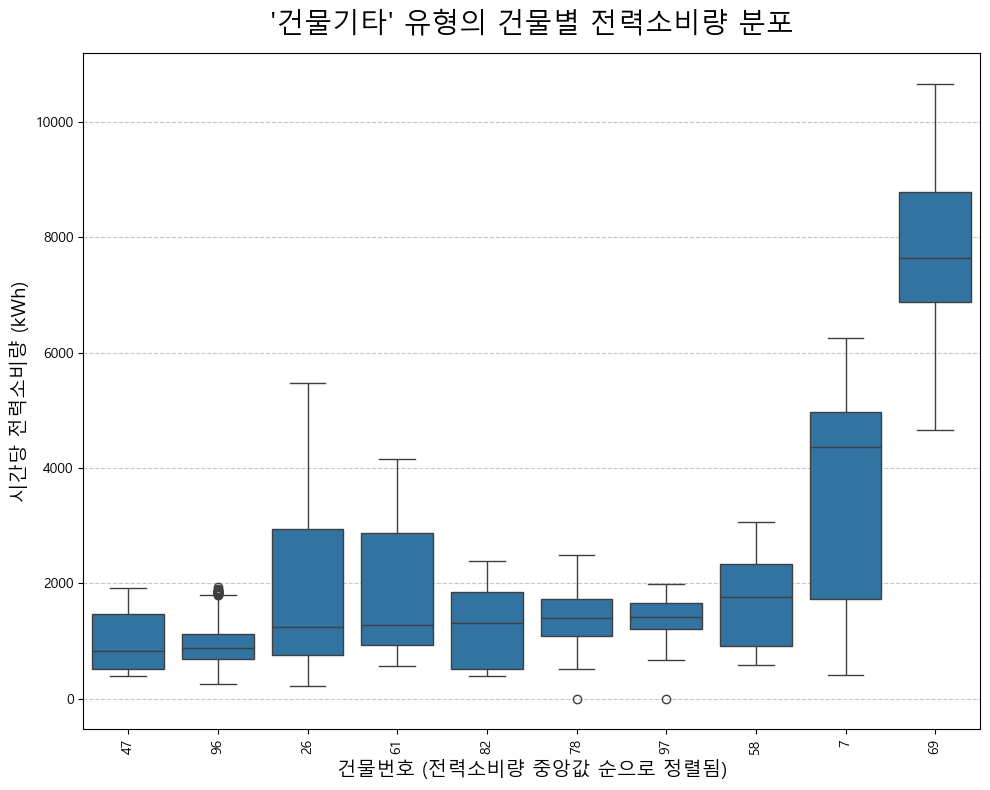

'건물유형별_전력소비량_분포_아파트.png' 파일이 저장되었습니다.


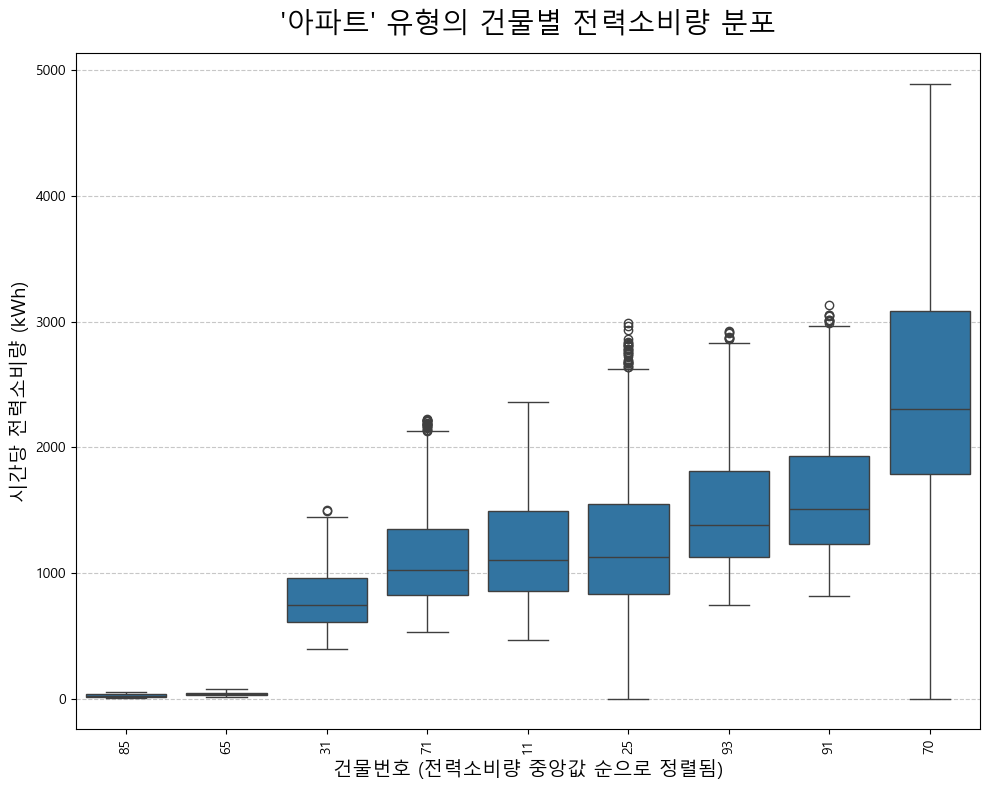

'건물유형별_전력소비량_분포_연구소.png' 파일이 저장되었습니다.


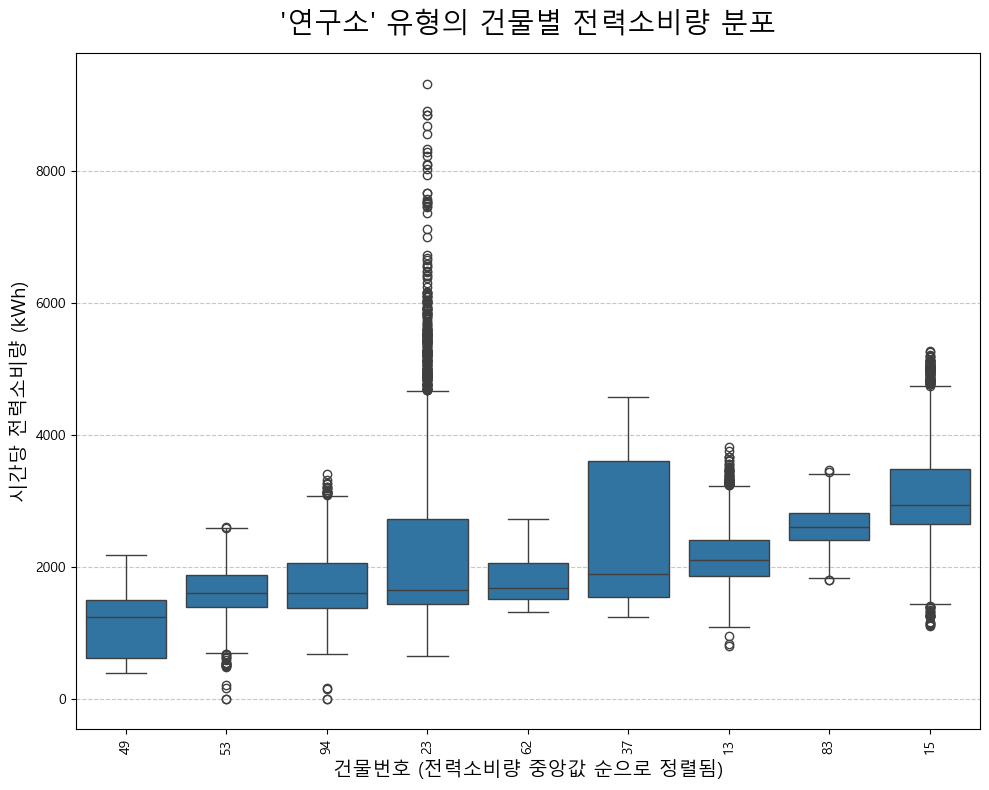

'건물유형별_전력소비량_분포_백화점.png' 파일이 저장되었습니다.


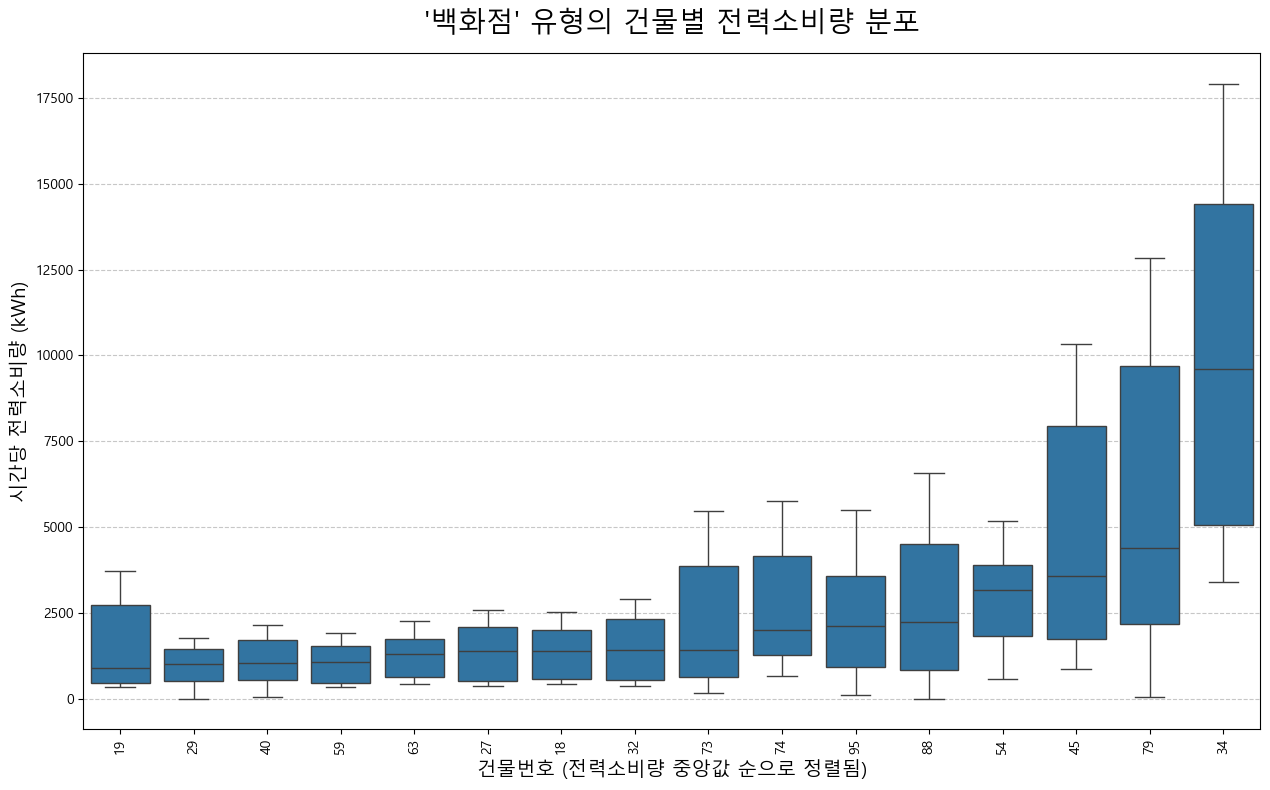

'건물유형별_전력소비량_분포_IDC(전화국).png' 파일이 저장되었습니다.


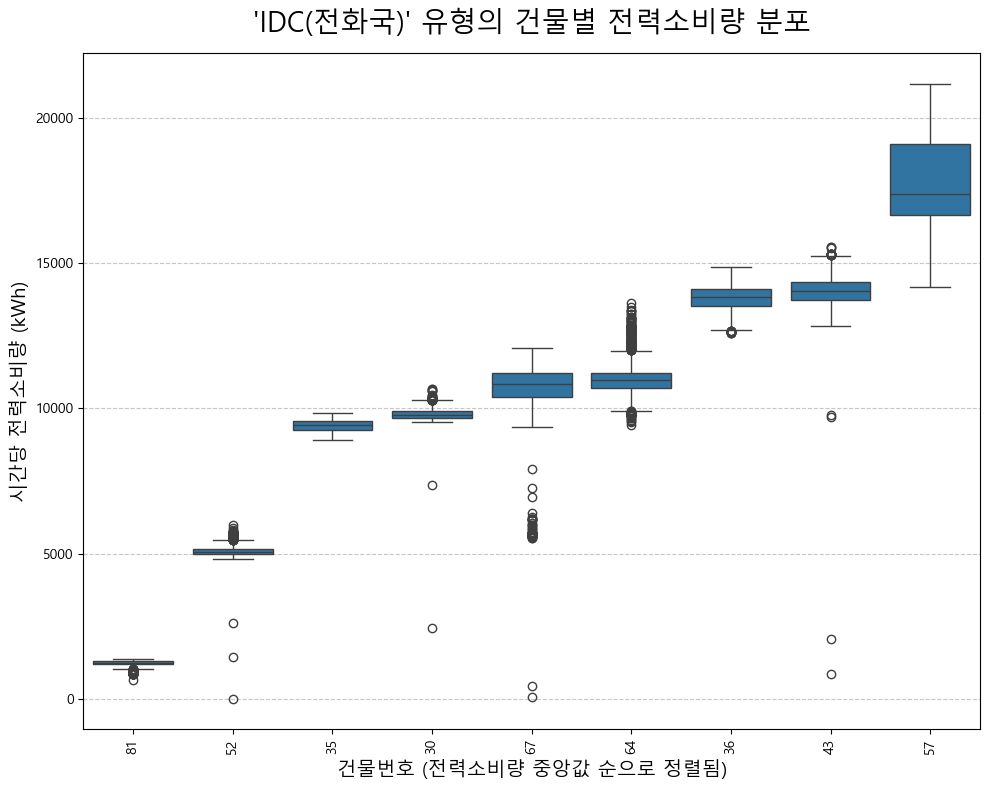

'건물유형별_전력소비량_분포_공공.png' 파일이 저장되었습니다.


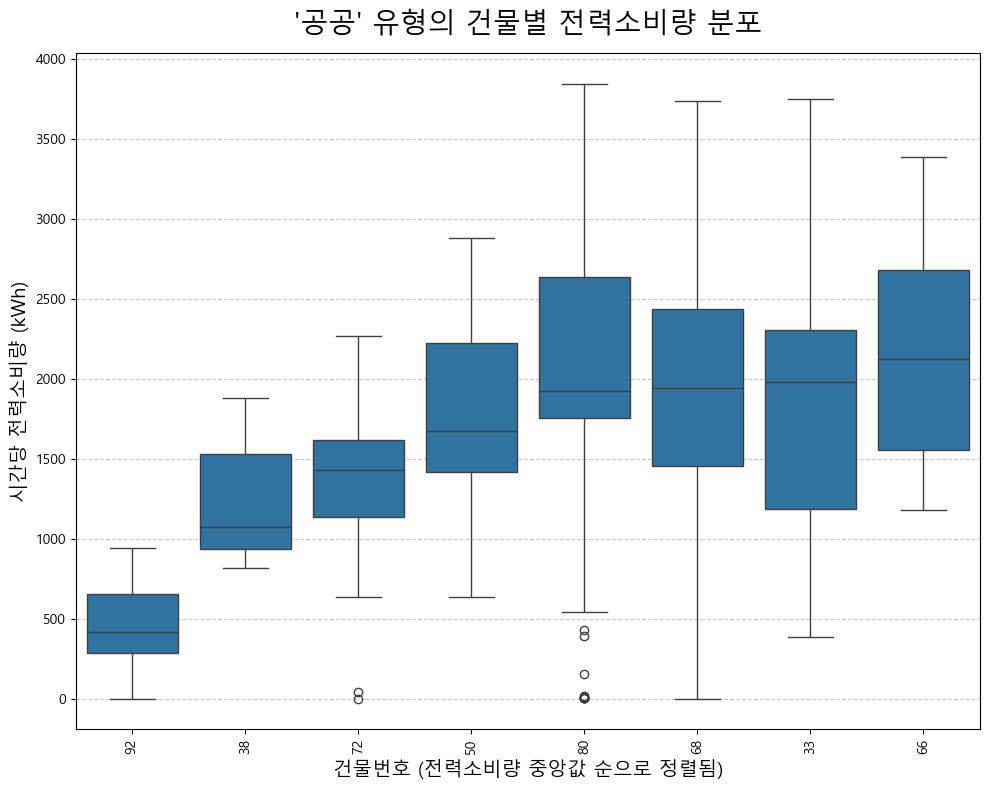


모든 그래프 생성이 완료되었습니다.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# '건물번호'를 기준으로 두 데이터를 병합합니다.
merged_df = pd.merge(train_df, building_info_df[['건물번호', '건물유형']], on='건물번호', how='left')

# 건물유형별 박스 플롯 생성 및 저장
unique_building_types = merged_df['건물유형'].unique()

for building_type in unique_building_types:


    type_df = merged_df[merged_df['건물유형'] == building_type]
    if type_df.empty:
        continue

    building_order = type_df.groupby('건물번호')['전력소비량(kWh)'].median().sort_values().index

    num_buildings = len(building_order)
    fig_width = max(10, num_buildings * 0.8)
    plt.figure(figsize=(fig_width, 8))

    ax = sns.boxplot(x='건물번호', y='전력소비량(kWh)', data=type_df, order=building_order)

    plt.title(f"'{building_type}' 유형의 건물별 전력소비량 분포", fontsize=20, pad=15)
    plt.xlabel('건물번호 (전력소비량 중앙값 순으로 정렬됨)', fontsize=14)
    plt.ylabel('시간당 전력소비량 (kWh)', fontsize=14)

    if num_buildings > 5:
        plt.xticks(rotation=90, fontsize=10)
    else:
        plt.xticks(fontsize=12)

    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    safe_building_type = building_type.replace('/', '_').replace('\\', '_')
    file_name = f'건물유형별_전력소비량_분포_{safe_building_type}.png'


    plt.savefig(file_name, dpi=300, bbox_inches='tight')

    plt.show()




'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
유형별/시간대별 평균 전력 소비량을 계산합니다...
평일, 주말, 공휴일의 시간대별 전력 소비 패턴을 시각화합니다...


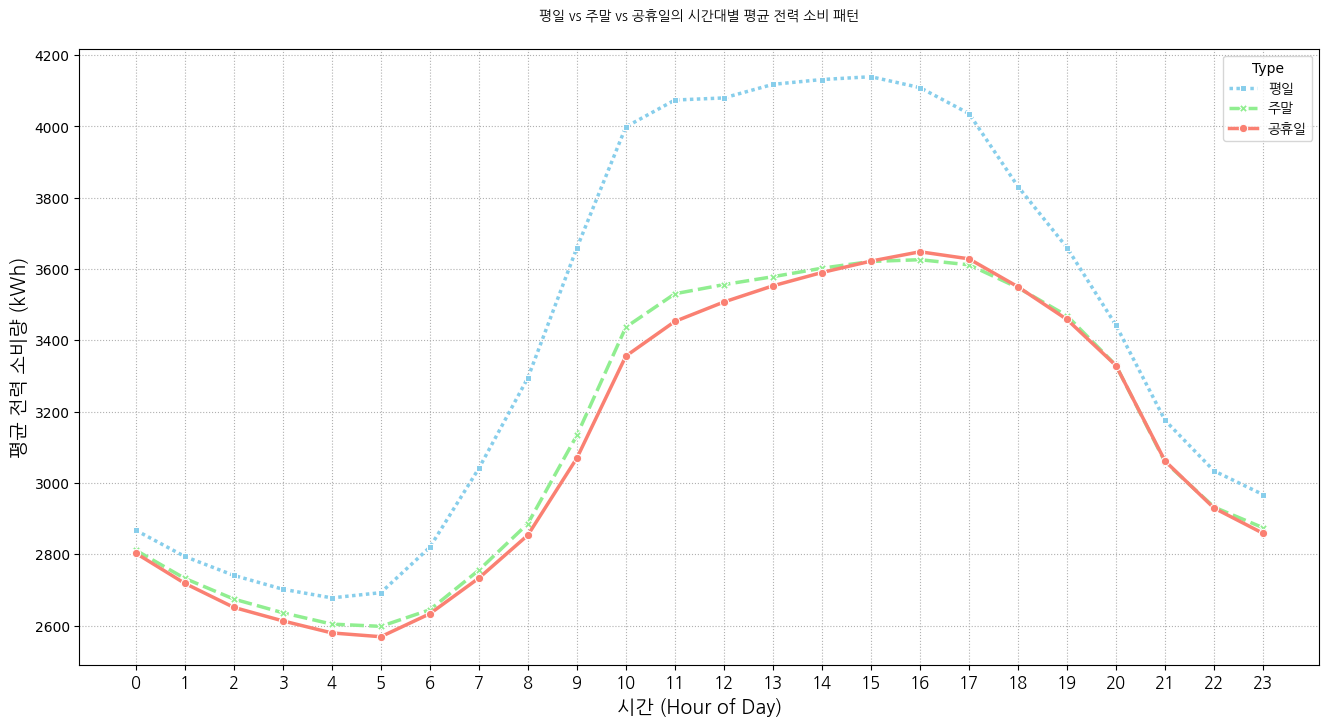

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
eda_df = train_df.copy()

# 평일/주말/공휴일 구분 변수 생성
eda_df['일시_dt'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df['weekday'] = eda_df['일시_dt'].dt.weekday
eda_df['hour'] = eda_df['일시_dt'].dt.hour # 시간대별 분석을 위해 hour 컬럼 추가
holidays = ['2024-06-06', '2024-08-15']
eda_df['is_holiday'] = eda_df['일시_dt'].dt.date.astype(str).isin(holidays)

def get_day_type(row):
    if row['is_holiday']:
        return '공휴일'
    elif row['weekday'] >= 5:
        return '주말'
    else:
        return '평일'
eda_df['day_type'] = eda_df.apply(get_day_type, axis=1)

print("유형별/시간대별 평균 전력 소비량을 계산합니다...")

avg_power_by_hour = eda_df.groupby(['day_type', 'hour'])['전력소비량(kWh)'].mean().reset_index()

print("평일, 주말, 공휴일의 시간대별 전력 소비 패턴을 시각화합니다...")

plt.figure(figsize=(16, 8))

sns.lineplot(
    data=avg_power_by_hour,
    x='hour',
    y='전력소비량(kWh)',
    hue='day_type', # day_type에 따라 다른 색상의 선을 그림
    hue_order=['평일', '주말', '공휴일'],
    style='day_type',
    markers=True,
    linewidth=2.5,
    palette={'평일': 'skyblue', '주말': 'lightgreen', '공휴일': 'salmon'}
)

if font_prop:
    plt.title('평일 vs 주말 vs 공휴일의 시간대별 평균 전력 소비 패턴', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('시간 (Hour of Day)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.xticks(np.arange(0, 24, 1), fontproperties=font_prop, fontsize=12)
    plt.legend(title='Type', prop=font_prop, fontsize=12)
else:
    plt.title('Average Hourly Power Consumption Pattern', fontsize=22, pad=20)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.xticks(np.arange(0, 24, 1), fontsize=12)
    plt.legend(title='분류', fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")



'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
온도별 평균 전력 소비량을 계산합니다...
전력 소비량 임계점(Threshold) 시각화를 시작합니다...


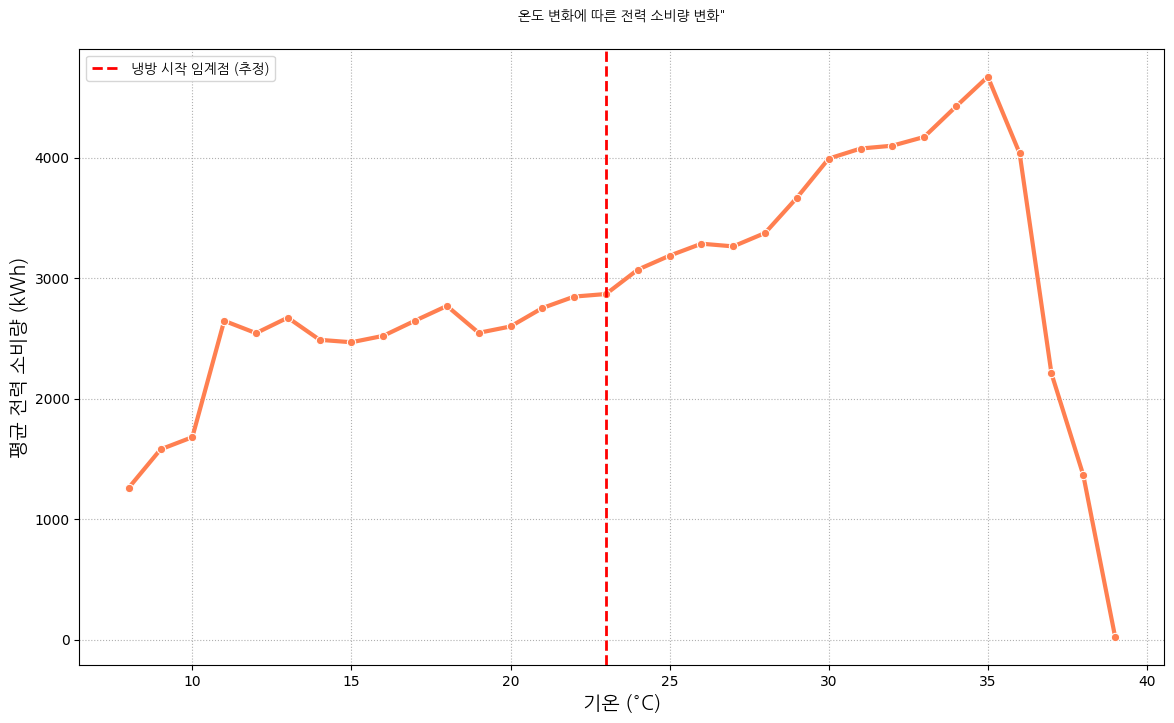

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("온도별 평균 전력 소비량을 계산합니다...")

eda_df = train_df.copy()
eda_df['기온_rounded'] = eda_df['기온(°C)'].round()

temp_vs_power = eda_df.groupby('기온_rounded')['전력소비량(kWh)'].mean().reset_index()

print("전력 소비량 임계점(Threshold) 시각화를 시작합니다...")

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=temp_vs_power,
    x='기온_rounded',
    y='전력소비량(kWh)',
    marker='o',
    linewidth=3,
    color='coral'
)

# 임계점을 시각적으로 강조
plt.axvline(x=23, color='red', linestyle='--', linewidth=2, label='냉방 시작 임계점 (추정)')

if font_prop:
    plt.title('온도 변화에 따른 전력 소비량 변화"', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('기온 (°C)', fontsize=14, fontproperties=font_prop)
    plt.ylabel('평균 전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12)

else:
    plt.title('"Threshold Effect" of Average Power Consumption by Temperature', fontsize=22, pad=20)
    plt.xlabel('Temperature (°C)', fontsize=14)
    plt.ylabel('Average Power Consumption (kWh)', fontsize=14)
    plt.legend(fontsize=12)

plt.grid(True, linestyle=':')
plt.show()

print("시각화가 완료되었습니다.")


'NanumGothic.ttf' 폰트를 그래프에 적용합니다.
데이터를 불러오는 중입니다...
데이터 로딩 완료.
시각화를 위한 데이터를 준비합니다...
이동평균 모형의 '노이즈 제거 및 추세 파악' 효과를 시각화합니다...


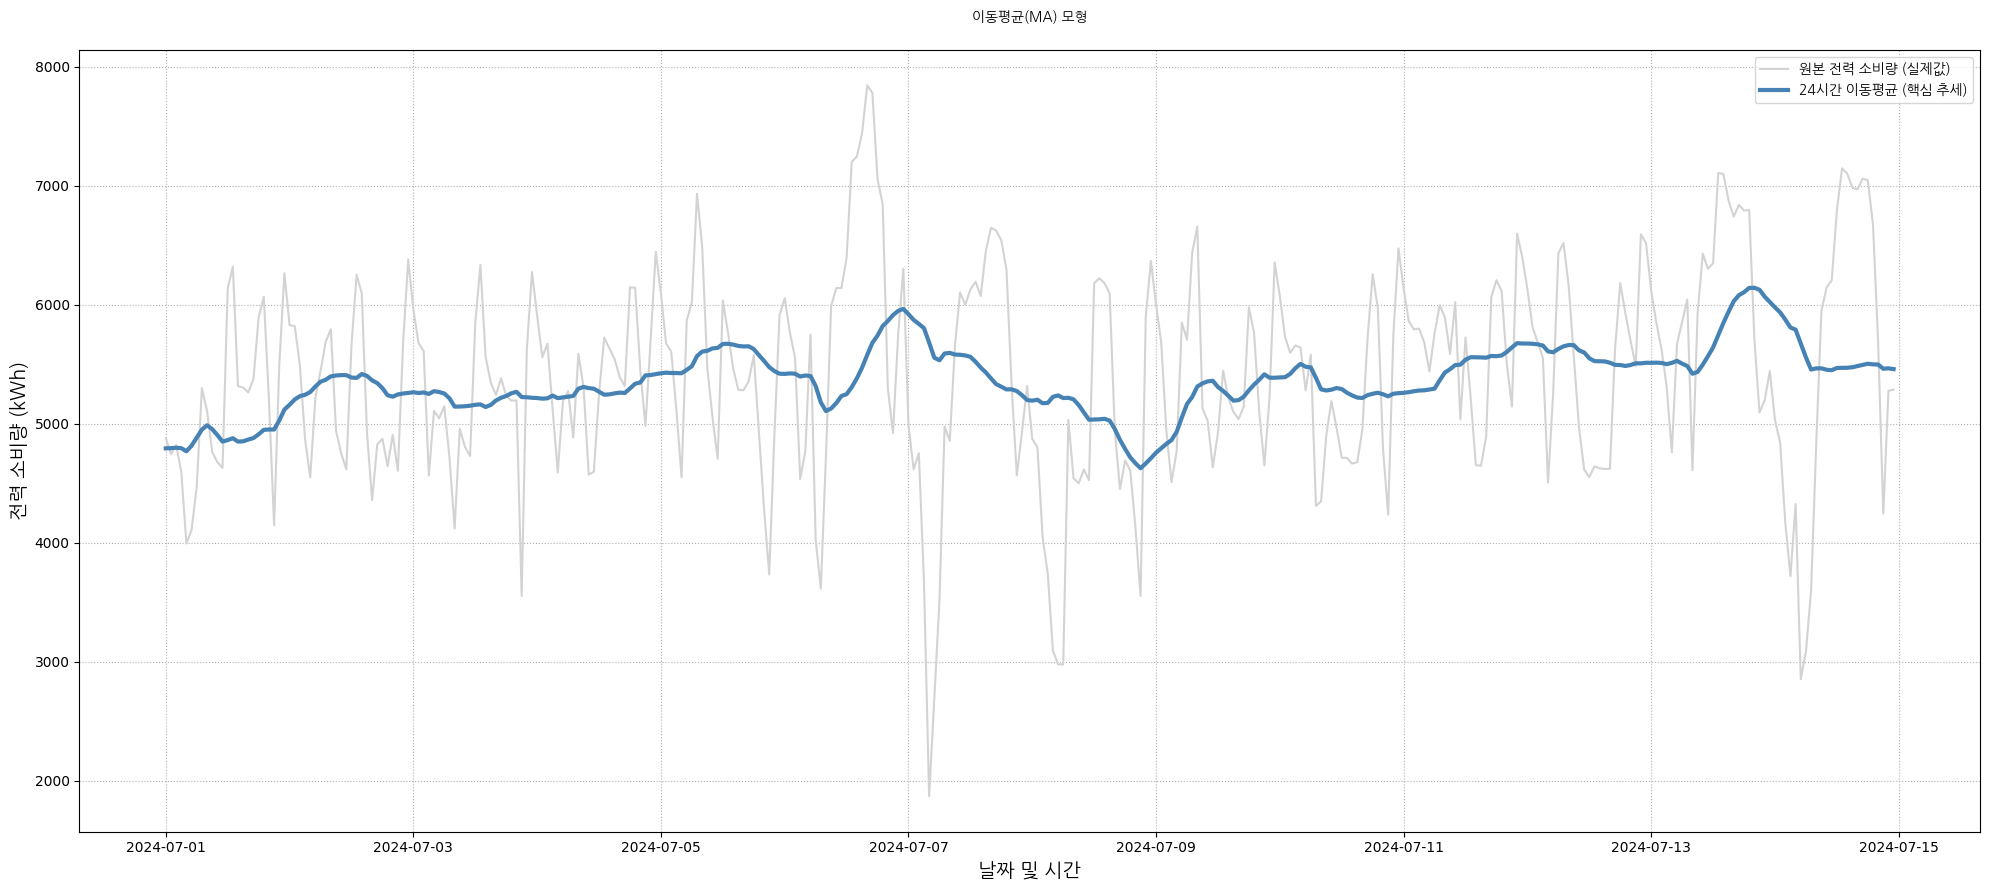

시각화가 완료되었습니다.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import urllib.request
from matplotlib import font_manager

print("시각화를 위한 데이터를 준비합니다...")
# 대표 건물 선택
building_num_to_analyze = 1
eda_df = train_df[train_df['건물번호'] == building_num_to_analyze].copy()
eda_df['일시'] = pd.to_datetime(eda_df['일시'], format='%Y%m%d %H')
eda_df = eda_df.set_index('일시')

eda_df['MA_24h'] = eda_df['전력소비량(kWh)'].rolling(window=24).mean()

eda_df_sample = eda_df['2024-07-01':'2024-07-14']

plt.figure(figsize=(20, 9))

plt.plot(eda_df_sample.index, eda_df_sample['전력소비량(kWh)'], color='lightgray', linewidth=1.5, label='원본 전력 소비량 (실제값)')

# 2. 24시간 이동평균 추세선
plt.plot(eda_df_sample.index, eda_df_sample['MA_24h'], color='steelblue', linewidth=3, label='24시간 이동평균 (핵심 추세)')

# 제목 및 라벨, 범례 설정
if font_prop:
    plt.title(f'이동평균(MA) 모형', fontsize=22, pad=20, fontproperties=font_prop)
    plt.xlabel('날짜 및 시간', fontsize=14, fontproperties=font_prop)
    plt.ylabel('전력 소비량 (kWh)', fontsize=14, fontproperties=font_prop)
    plt.legend(prop=font_prop, fontsize=12, loc='upper right')

else:
    plt.title(f'Effect of Moving Average: Smoothing Noise & Identifying Trend (Building #{building_num_to_analyze})', fontsize=22, pad=20)
    plt.xlabel('Date and Time', fontsize=14)
    plt.ylabel('Power Consumption (kWh)', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')

plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

print("시각화가 완료되었습니다.")


In [ ]:
# 1. Import Libraries
import pandas as pd
import warnings

print("\n'습도(%)'가 0인 데이터를 추출합니다...")
zero_humidity_df = train_df[train_df['습도(%)'] == 0].copy()

if not zero_humidity_df.empty:
    print(f"\n총 {len(zero_humidity_df)}개의 '습도 0' 데이터를 발견했습니다.")
    print("--- 추출된 데이터 (상위 20개) ---")

    zero_humidity_df['일시_dt'] = pd.to_datetime(zero_humidity_df['일시'], format='%Y%m%d %H')
    zero_humidity_df['요일'] = zero_humidity_df['일시_dt'].dt.day_name()
    zero_humidity_df['시간'] = zero_humidity_df['일시_dt'].dt.hour

    # 주요 컬럼만 선택하여 출력
    display_cols = ['건물번호', '일시', '요일', '시간', '기온(°C)', '강수량(mm)', '습도(%)', '전력소비량(kWh)']
    print(zero_humidity_df[display_cols].head(20).to_string())

    print("\n\n--- '습도 0' 데이터 요약 ---")
    print("\n[건물번호별 발생 빈도]")
    print(zero_humidity_df['건물번호'].value_counts().head())
    print("\n[시간대별 발생 빈도]")
    print(zero_humidity_df['시간'].value_counts().sort_index())

else:
    print("\n'습도(%)'가 0인 데이터는 발견되지 않았습니다.")


데이터를 불러오는 중입니다...
데이터 로딩 완료.

'습도(%)'가 0인 데이터를 추출합니다...

총 49개의 '습도 0' 데이터를 발견했습니다.
--- 추출된 데이터 (상위 20개) ---
        건물번호           일시         요일  시간  기온(°C)  강수량(mm)  습도(%)  전력소비량(kWh)
115801    57  20240805 01     Monday   1    27.5      0.6    0.0    20602.26
115802    57  20240805 02     Monday   2    27.3      0.0    0.0    20520.06
115803    57  20240805 03     Monday   3    26.9      0.0    0.0    20394.06
115804    57  20240805 04     Monday   4    26.6      0.0    0.0    20238.00
115805    57  20240805 05     Monday   5    26.4      0.0    0.0    20124.54
115806    57  20240805 06     Monday   6    26.4      0.0    0.0    19721.58
115810    57  20240805 10     Monday  10    29.8      0.0    0.0    17445.18
115811    57  20240805 11     Monday  11    31.0      0.0    0.0    17624.70
115812    57  20240805 12     Monday  12    31.9      0.0    0.0    17572.74
115813    57  20240805 13     Monday  13    33.2      0.0    0.0    17576.64
115814    57  20240805 14     Monday  14    